<a href="https://colab.research.google.com/github/superpanditas/Quinio/blob/main/%5BForecasting_Units%5D_By_Stores_and_Items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0 - Getting Started

**Business Problem:** A company is getting stock outs due to don't have enought ...

Help the Tech and Product Team to forecast units sold
The approach followed is begin to forecast units sold by all company, after by stores and finally by items. The goal is to forecast units sold by ...



In [3]:
# @title Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np


plt.style.use('ggplot')

In [5]:
# @title Load Data
df = pd.read_csv('/content/Productlevel_Sales_Transactions_Dataset_Weekly.csv')

# Step 1 - Data Cleaning


In [6]:
# @title Reshaping DataFrame

'''
Transform the DataFrame to adjust it to analysis, where each row represents a single store,
a weekly and the units sold
'''

id_vars = ['Scode', 'Pcode', 'Price']
value_var = ['Wk'+str(i) for i in range(0,104)]
var_name = 'weekly'
value_name = 'units'

# rename columns
new_col_names = ['store', 'item', 'price', 'weekly', 'units']

# compute melt function to change the data format
sales = df.melt(id_vars=id_vars, value_vars=value_var, var_name=var_name, value_name=value_name)
sales.columns = new_col_names

In [7]:
# @title Duplicate Values

'''
The dataframe has different prices for some values ​​['weekly', 'store', 'price'], ...
for simplicity, we will sum all units by 'weekly', 'store' and 'price' columns and omit the unit price column
'''

sales = sales.groupby(['weekly', 'store', 'item'])['units'].sum().reset_index()

In [8]:
# @title Weekly Dates

'''
It's more useful have real weekly dates, so we're going to add a column of dates
'''

# initialize of first weekly date (Note that weeks start on sundays)
init_week = pd.to_datetime('2023-01-07')

# create a function to compute mapping from weekly column to weekly dates according to the number of week
def calculate_date(weekly):
  week_number = int(weekly[2:])
  return init_week + timedelta(weeks=week_number)

sales['weekly_date'] = sales['weekly'].apply(calculate_date)

In [9]:
# @title Weekly and Monthly DataFrame

'''
There'are multiple prices for some items in the same timeframe, so for simplicity
we're going to eliminate 'price' column and sum units.
'''

# create the dataframe called 'weekly_sales_by_store'
weekly_sales_by_store = sales.copy()

# drop "weekly" column
weekly_sales_by_store = weekly_sales_by_store.drop('weekly', axis=1)

# data grouped
weekly_sales_by_store = weekly_sales_by_store.groupby(['weekly_date', 'store', 'item'])['units'].sum().reset_index()

# set index 'weekly_date' column
weekly_sales_by_store = weekly_sales_by_store.set_index('weekly_date')
weekly_sales_by_store.index = pd.to_datetime(weekly_sales_by_store.index)

# -------

# create the dataframe called 'monthly_sales_by_store' using resample function

monthly_sales_by_store = weekly_sales_by_store.copy()
# compute resample function
monthly_sales_by_store = monthly_sales_by_store.groupby(['store', 'item']).resample('M')['units'].sum().reset_index()

# set and rename index 'weekly_date' column to 'monthly date'
monthly_sales_by_store = monthly_sales_by_store.set_index('weekly_date')
monthly_sales_by_store = monthly_sales_by_store.rename_axis('monthly_date')


# Step 2 - Data Understanding

Analysis Highlights:
  
  Weekly Units (From Jan to Oct): 2023 vs 2024
    - The units sold WoW keep similar behavior between Jan-Oct but Nov-Dec ...

In [10]:
# @title Monthly and Weekly Stats (DataFrame)
# create 'df_monthly' and 'df_weekly' dataframe to calculate stats
df_monthly = monthly_sales_by_store.copy()
df_weekly = weekly_sales_by_store.copy()

# add 'year' and 'month' column
df_monthly['year'] = df_monthly.index.year
df_monthly['month'] = df_monthly.index.month

df_weekly['year'] = df_weekly.index.year
df_weekly['month'] = df_weekly.index.month

# create 'monthly_stats' dataframe
monthly_stats = df_monthly.groupby(['monthly_date']).agg({
    'units': [lambda x: np.percentile(x, 25), 'median', lambda x: np.percentile(x, 95), 'sum', 'max'],
    'item': 'nunique'
})

monthly_stats.columns = ['25th_perc', 'median', '95th_perc', 'total', 'max', 'total_items']
monthly_stats['pct_change'] = np.round(100 * monthly_stats['total'].pct_change(12),2)
monthly_stats['diff'] = np.round(monthly_stats['total'].diff(12))

# create 'monthly_stats_by_store' dataframe
monthly_stats_by_store = df_monthly.groupby(['monthly_date', 'store']).agg({
    'units': [lambda x: np.percentile(x, 25), 'median', lambda x: np.percentile(x, 95), 'sum', 'max'],
    'item': 'nunique'
})

monthly_stats_by_store.columns = ['25th_perc', 'median', '95th_perc', 'total', 'max', 'total_items']
monthly_stats_by_store['pct_change'] = np.round(100 * monthly_stats_by_store['total'].pct_change(12),2)
monthly_stats_by_store['diff'] = np.round(monthly_stats_by_store['total'].diff(12))

monthly_stats_by_store = monthly_stats_by_store.reset_index('store')

# create 'weekly_stats' dataframe
weekly_stats = df_weekly.groupby(['weekly_date']).agg({
    'units': [lambda x: np.percentile(x, 25), 'median', lambda x: np.percentile(x, 95), 'sum', 'max'],
    'item': 'nunique'
})

weekly_stats.columns = ['25th_perc', 'median', '95th_perc', 'total', 'max', 'total_items']
weekly_stats['pct_change'] = np.round(100 * weekly_stats['total'].pct_change(52),2)
weekly_stats['diff'] = np.round(weekly_stats['total'].diff(53))

# create 'weekly_stats_by_store' dataframe
weekly_stats_by_store = df_weekly.groupby(['weekly_date', 'store']).agg({
    'units': [lambda x: np.percentile(x, 25), 'median', lambda x: np.percentile(x, 95), 'sum', 'max'],
    'item': 'nunique'
})

weekly_stats_by_store.columns = ['25th_perc', 'median', '95th_perc', 'total', 'max', 'total_items']
weekly_stats_by_store['pct_change'] = np.round(100 * weekly_stats_by_store['total'].pct_change(12),2)
weekly_stats_by_store['diff'] = np.round(weekly_stats_by_store['total'].diff(12))

weekly_stats_by_store = weekly_stats_by_store.reset_index('store')

In [19]:
def timeseries_plot(df, date_format, year_one, year_two, start_month, end_month, y_lim, title='weekly'):

  start_date_one = year_one + '-' + start_month
  end_date_one = year_one + '-' + end_month

  start_date_two = year_two + '-' + start_month
  end_date_two = year_two + '-' + end_month


  title_one = title + ' ' + 'Units Sold (2023): 25th, 50th and 95th Percentile'
  title_two = title + ' ' + 'Units Sold (2024): 25th, 50th and 95th Percentile'

  y_lim_one = y_lim
  y_lim_two = y_lim

  date_format = date_format
  stats = df

  # -------

  fig, ax = plt.subplots(2, 1, sharey=False, figsize=(15, 14))

  ax[0].set_title(title_one)
  ax[0].plot(stats[start_date_one:end_date_one].index.strftime(date_format),
            stats[start_date_one:end_date_one]['median'])
  ax[0].plot(stats[start_date_one:end_date_one].index.strftime(date_format),
            stats[start_date_one:end_date_one]['25th_perc'],
            linestyle='--')
  ax[0].plot(stats[start_date_one:end_date_one].index.strftime(date_format),
            stats[start_date_one:end_date_one]['95th_perc'],
            linestyle='--')
  ax[0].set_ylim(0, y_lim_one)
  ax[0].tick_params(axis='x', rotation=90)

  ax[1].set_title(title_two)
  ax[1].plot(stats[start_date_two:end_date_two].index.strftime(date_format),
            stats[start_date_two:end_date_two]['median'])
  ax[1].plot(stats[start_date_two:end_date_two].index.strftime(date_format),
            stats[start_date_two:end_date_two]['25th_perc'],
            linestyle='--')
  ax[1].plot(stats[start_date_two:end_date_two].index.strftime(date_format),
            stats[start_date_two:end_date_two]['95th_perc'],
            linestyle='--')
  ax[1].set_ylim(0, y_lim_two)
  ax[1].tick_params(axis='x', rotation=90)

  plt.show()

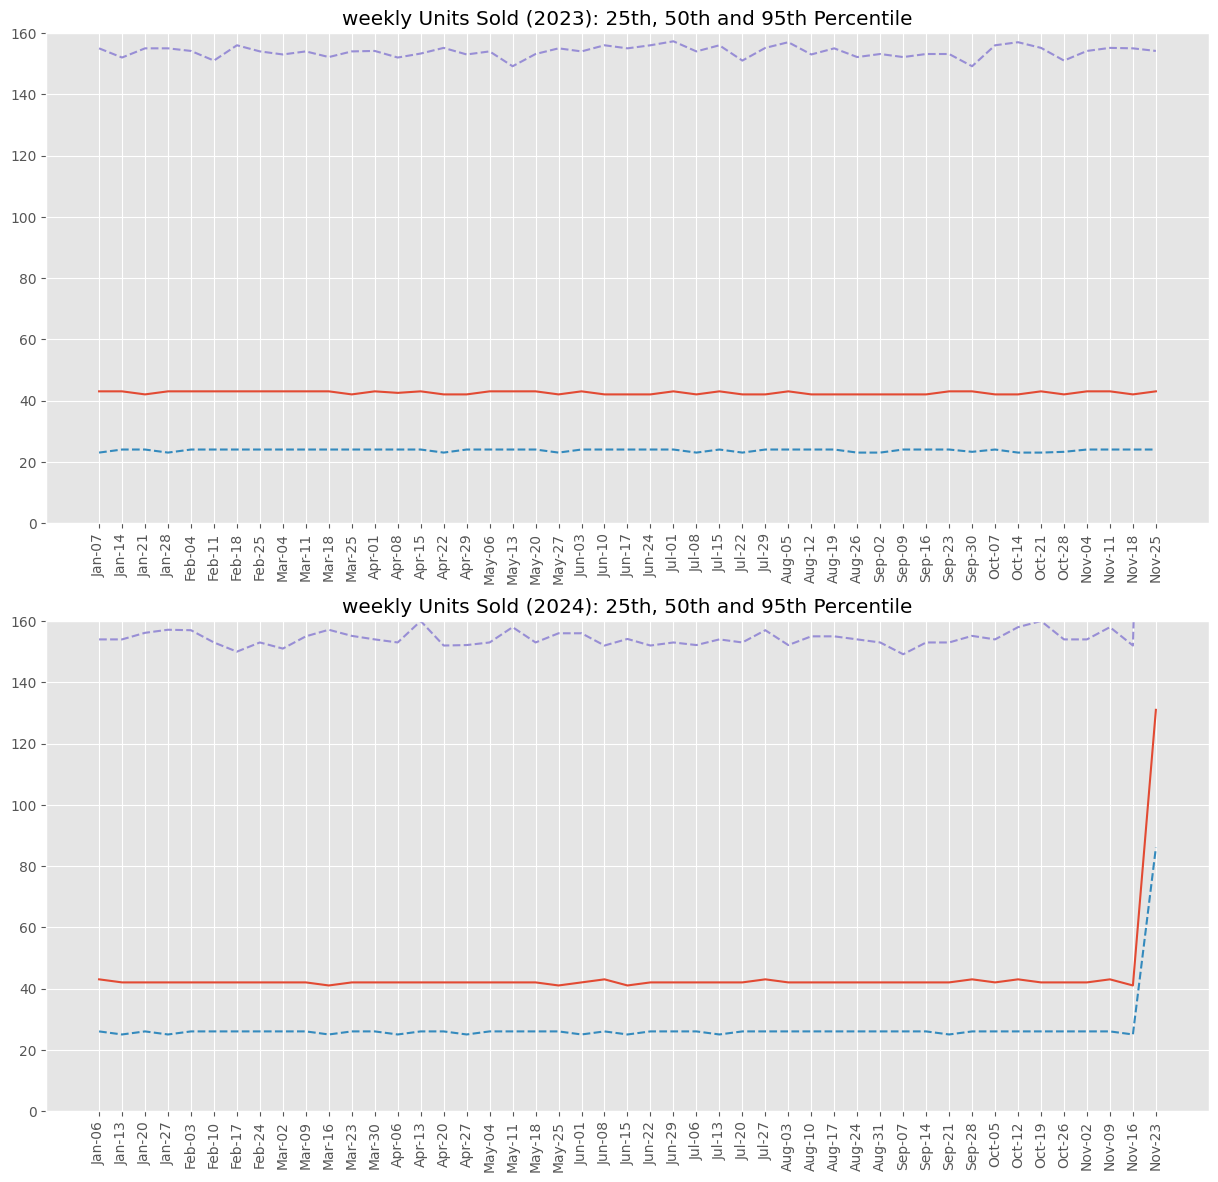

In [376]:
# @title  Weekly Units: 2023 vs 2024 (Jan-Oct)
timeseries_plot(weekly_stats, '%b-%d', '2023', '2024', '01-01', '11-25', 160, 'weekly')

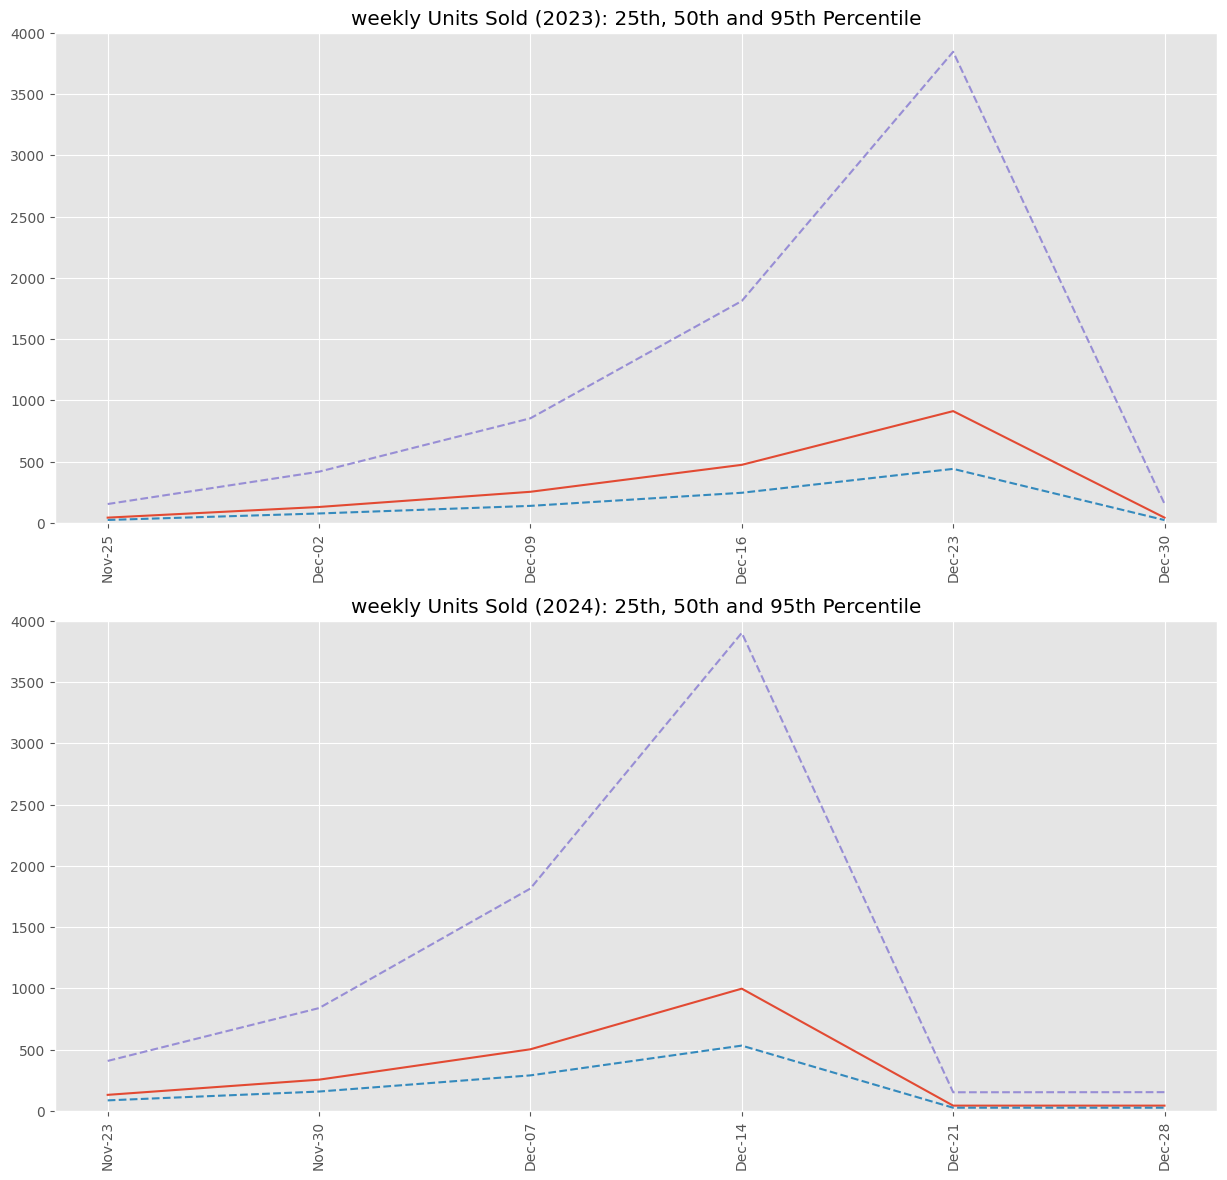

In [378]:
# @title Weekly Units: 2023 vs 2024 (Nov-Dic)
timeseries_plot(weekly_stats, '%b-%d', '2023', '2024', '11-23', '12-31', 4000, 'weekly')

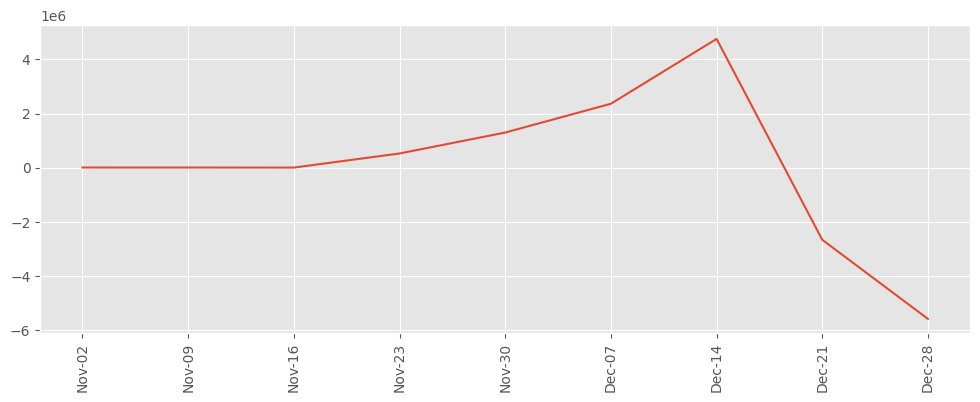

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(weekly_stats['2024-11-01':'2024-12-31'].index.strftime('%b-%d'), weekly_stats['2024-11-01':'2024-12-31']['diff'])
ax.tick_params(axis='x', rotation=90)
# ax.set_ylim(0, 5)
plt.show()

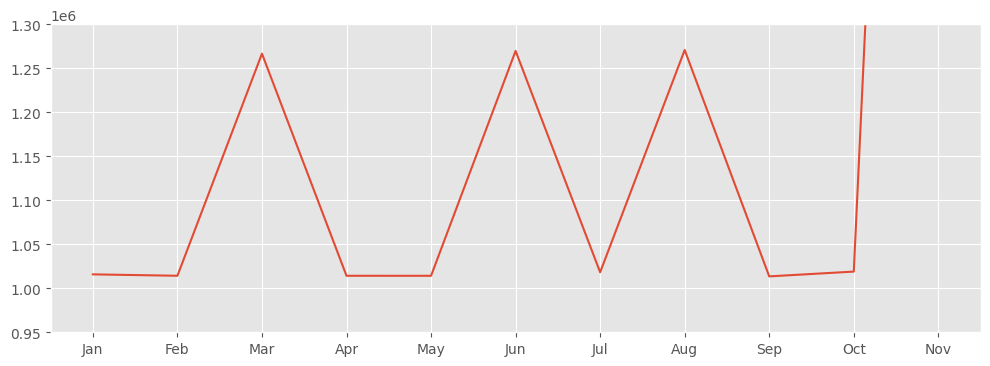

In [261]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(monthly_stats['2024-01-01':'2024-11-30'].index.strftime('%b'), monthly_stats['2024-01-01':'2024-11-30']['total'])
plt.ylim([950000, 1300000])
plt.show()

In [22]:
# df_monthly[(df_monthly['year'] == 2023) & (df_monthly['month'] == 11) & (df_monthly['units'] > 800)].sort_values('units', ascending=False)
# df_monthly[(df_monthly['item'] == 'SKU321') & (df_monthly['store'] == 'Store5')].head(24)


# Step 3 - Feauture Engineering

- Lags
- Seasonality
- Month
- ...

In [30]:
# @title Lags

# -------
num_lags = 13
window_size = 3

for lag_n in range(7, num_lags):
  # create the lag_12 column by grouping by store
  company_sales_by_monthly[f'lag_{lag_n}'] = company_sales_by_monthly.groupby(['store'])['units'].shift(lag_n)

  # compute EWMA for the 'units' column and use it to fill NaN values in the 'lag_12' column
  ewma_filled_values = company_sales_by_monthly.groupby('store')['units'].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())

  # fill NaN values in the 'lag_12' column using the computed EWMA values
  company_sales_by_monthly[f'lag_{lag_n}'] = company_sales_by_monthly[f'lag_{lag_n}'].fillna(np.round(ewma_filled_values,2))
# -------


<ipython-input-30-6ad5ceb3e573>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  company_sales_by_monthly[f'lag_{lag_n}'] = company_sales_by_monthly.groupby(['store'])['units'].shift(lag_n)
<ipython-input-30-6ad5ceb3e573>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ewma_filled_values = company_sales_by_monthly.groupby('store')['units'].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())


In [ ]:
# Calculate pct change 2023 vs 2024
company_sales_23_vs_24 = company_sales_by_monthly[company_sales_by_monthly.index.year == 2024]

company_sales_23_vs_24['pct_change'] = np.round(100 * ((company_sales_23_vs_24['units']/company_sales_23_vs_24['lag_12']) - 1), 2)

'''
Let's see how the month of Nov-24 had a high growth compared to the Nov-23
>200% growth - Noticed how it behavior will be affecting the accuracy of forecast because is atypical, althought we can see
there is a strong relation between units and lag_12_months

Facts:
- Store 1 has the most growth 23 vs 24 (%)
- November is the month with high growth 23 vs 24 (>200%)
-
'''

for store_name, store_data in company_sales_23_vs_24.groupby('store'):
  print(store_name)
  print('Units Sold 23:', store_data['lag_12'].sum())
  print('Units Sold 24:', store_data['units'].sum())
  print(store_data[['pct_change']].describe().round(2))

In [8]:
# Add exponential moving average to capture trend in the short-term
# company_sales_by_monthly['rolling_mean_3'] = np.round(company_sales_by_monthly['units'].rolling(window=3).mean(),2)
# company_sales_by_monthly['ewm_3'] = np.round(company_sales_by_monthly['units'].ewm(span=3, adjust=False).mean(), 2)


# add seasonal pattern column
company_sales_by_monthly.loc[company_sales_by_monthly.index.month.isin([11, 12]), 'seasonal_pattern'] = 1
company_sales_by_monthly.loc[~company_sales_by_monthly.index.month.isin([11, 12]), 'seasonal_pattern'] = 0

# add month column
company_sales_by_monthly['month'] = company_sales_by_monthly.index.month

# cast index as DatetimeIndex
company_sales_by_monthly.index = pd.to_datetime(company_sales_by_monthly.index)
# sort the DatetimeIndex
company_sales_by_monthly = company_sales_by_monthly.sort_index()

# Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
company_sales_by_monthly['store_encoded'] = le.fit_transform(company_sales_by_monthly['store'])

'''
# add difference from 12 months ago
company_sales_by_monthly['diff_12'] = company_sales_by_monthly.groupby('store')['units'].diff(12)

# compute diff_1 for the 'units' column and use it to fill NaN values in the 'diff_12' column
diff_filled_values = company_sales_by_monthly.groupby('store')['units'].transform(lambda x: x.diff(1))

# fill NaN values in the 'diff_12' column using the computed diff_1 values
company_sales_by_monthly['diff_12'] = company_sales_by_monthly['diff_12'].fillna(np.round(diff_filled_values,2))
'''

'''
# compute diff_1 for the 'units' column
company_sales_by_monthly['diff_1'] = company_sales_by_monthly.groupby('store')['units'].diff(1)

# compute rolling mean 3 window for the 'units' column
company_sales_by_monthly['rolling_mean_3'] = company_sales_by_monthly.groupby('store', as_index=False)['units'].transform(lambda x: x.rolling(window=3).mean().round(2))

# compute rolling std 3 window for the 'units' column
company_sales_by_monthly['rolling_std_3'] = company_sales_by_monthly.groupby('store', as_index=False)['units'].transform(lambda x: x.rolling(window=3).std().round(2))
'''

# company_sales_by_monthly['2023-11':'2024-12']

# company_sales_by_monthly[company_sales_by_monthly['store'] == 'Store1'].head(24)

"\n# compute diff_1 for the 'units' column\ncompany_sales_by_monthly['diff_1'] = company_sales_by_monthly.groupby('store')['units'].diff(1)\n\n# compute rolling mean 3 window for the 'units' column\ncompany_sales_by_monthly['rolling_mean_3'] = company_sales_by_monthly.groupby('store', as_index=False)['units'].transform(lambda x: x.rolling(window=3).mean().round(2))\n\n# compute rolling std 3 window for the 'units' column\ncompany_sales_by_monthly['rolling_std_3'] = company_sales_by_monthly.groupby('store', as_index=False)['units'].transform(lambda x: x.rolling(window=3).std().round(2))\n"

In [9]:
company_sales_by_monthly.head()

,store,units,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,seasonal_pattern,month,store_encoded
monthly_date,,,,,,,,,,,
2023-01-31,Store1,69864,69864.0,69864.0,69864.0,69864.0,69864.0,69864.0,0.0,1,0
2023-01-31,Store5,210402,210402.0,210402.0,210402.0,210402.0,210402.0,210402.0,0.0,1,4
2023-01-31,Store2,199780,199780.0,199780.0,199780.0,199780.0,199780.0,199780.0,0.0,1,1
2023-01-31,Store4,209241,209241.0,209241.0,209241.0,209241.0,209241.0,209241.0,0.0,1,3
2023-01-31,Store3,296904,296904.0,296904.0,296904.0,296904.0,296904.0,296904.0,0.0,1,2


The last 12 period is relevant for forecasting


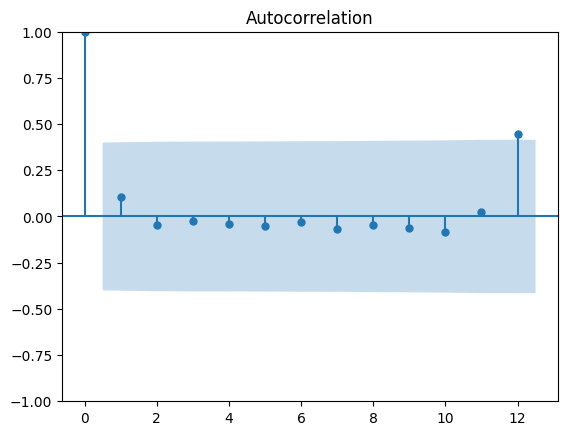

In [ ]:
# Can use 12 months ago in series for forecasting
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(company_sales_by_monthly[company_sales_by_monthly['store'] == 'Store1'].units, lags=12, alpha=0.05)
print("The last 12 period is relevant for forecasting")

In [ ]:
# company_sales_by_monthly['lag_12_months'] = company_sales_by_monthly['lag_12_months'].fillna(company_sales_by_monthly['units'].ewm(span=3, adjust=False).mean().round(2))
# company_sales_by_monthly['lag_10_months'] = company_sales_by_monthly['lag_10_months'].fillna(company_sales_by_monthly['units'].ewm(span=2, adjust=False).mean().round(2))
# company_sales_by_monthly.head(24)

# Step 4 - Data Modeling

In [10]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# company_sales_by_monthly = company_sales_by_monthly.set_index('monthly_date')
company_sales_by_monthly_train = company_sales_by_monthly['2023-01-01':'2024-06-01']
company_sales_by_monthly_test = company_sales_by_monthly['2024-06-01':'2024-12-31']

x_train, y_train = company_sales_by_monthly_train[['lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'month', 'store_encoded']], company_sales_by_monthly_train['units']
x_test, y_test = company_sales_by_monthly_test[['lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'month', 'store_encoded']], company_sales_by_monthly_test['units']


param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'lambda': [0, 1],
    'alpha': [0, 1]
}

random_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(), param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=5)
random_search.fit(x_train, y_train)
print("Best Parameters: ", random_search.best_params_)

Best Parameters:  {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 0, 'gamma': 0.2, 'colsample_bytree': 0.8, 'alpha': 1}


In [11]:
from sklearn.metrics import mean_squared_error

best_params = random_search.best_params_  # or random_search.best_params_
model_best = xgb.XGBRegressor(**best_params)
model_best.fit(x_train, y_train)
y_pred_best = model_best.predict(x_test)
print("Best Model MSE: ", mean_squared_error(y_test, y_pred_best))
print("Best Model RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_best)))

Best Model MSE:  47148022032.699104
Best Model RMSE:  217135.95287906402


# Step 5 - Data Evaluation

In [12]:
# Get feature importance
feature_importances = model_best.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df.sort_values('Importance', ascending=False).head(10)

,Feature,Importance
5,lag_12,0.473666
6,month,0.410322
1,lag_8,0.049443
7,store_encoded,0.027870
0,lag_7,0.016534
3,lag_10,0.015621
4,lag_11,0.003808
2,lag_9,0.002736


In [13]:
company_sales_by_monthly_test['pred'] = y_pred_best

company_sales_by_monthly_test['error'] = company_sales_by_monthly_test['pred'] - company_sales_by_monthly_test['units']
company_sales_by_monthly_test.sort_values('error', ascending=False).round(2).head(35)

<ipython-input-13-63192717cbe3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_sales_by_monthly_test['pred'] = y_pred_best
<ipython-input-13-63192717cbe3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_sales_by_monthly_test['error'] = company_sales_by_monthly_test['pred'] - company_sales_by_monthly_test['units']


,store,units,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,seasonal_pattern,month,store_encoded,pred,error
monthly_date,,,,,,,,,,,,,
2024-12-31,Store4,1926318,209753.0,211161.0,261848.0,209443.0,209771.0,2267464.0,1.0,12,3,2.579540e+06,653221.75
2024-12-31,Store5,1948765,209951.0,210199.0,262241.0,210183.0,210074.0,2290382.0,1.0,12,4,2.579480e+06,630714.75
2024-12-31,Store3,2507423,297686.0,296689.0,371107.0,298905.0,298568.0,2980878.0,1.0,12,2,2.818645e+06,311221.75
2024-12-31,Store2,2502823,197997.0,198760.0,249110.0,196345.0,199386.0,2944973.0,1.0,12,1,2.740283e+06,237460.00
2024-08-31,Store1,124049,98026.0,725938.0,67354.0,66267.0,82423.0,65070.0,0.0,8,0,3.453159e+05,221266.91
2024-08-31,Store4,261167,209771.0,2267464.0,210062.0,209739.0,261748.0,209388.0,0.0,8,3,4.371847e+05,176017.69
2024-08-31,Store5,262885,210074.0,2290382.0,211161.0,210315.0,263870.0,209904.0,0.0,8,4,4.377748e+05,174889.84
2024-08-31,Store2,250769,199386.0,2944973.0,201377.0,202099.0,252982.0,199405.0,0.0,8,1,4.134074e+05,162638.41
2024-10-31,Store1,98301,122325.0,99339.0,98026.0,725938.0,67354.0,66267.0,0.0,10,0,2.554736e+05,157172.58


<Axes: xlabel='monthly_date'>

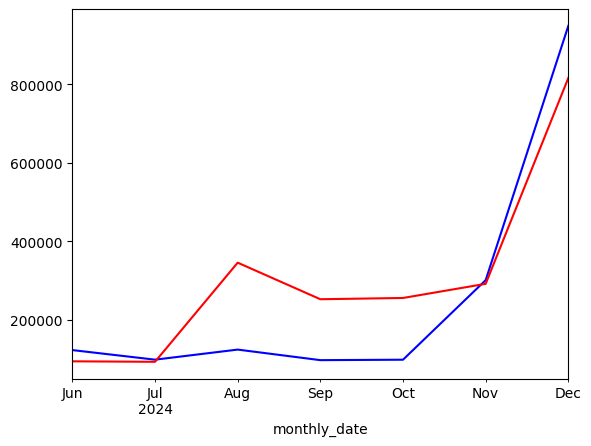

In [14]:
plot_by_store = company_sales_by_monthly_test[company_sales_by_monthly_test['store'] == 'Store1']['2024-06-01':'2024-12-31']
plot_by_store['units'].plot(color='blue')
plot_by_store['pred'].plot(color='red')

In [15]:
company_monthly_agg = company_sales_by_monthly_test.reset_index().groupby(['monthly_date']).agg({'units':'sum', 'lag_12':'sum', 'pred':'sum'}).round(0)
company_monthly_agg

,units,lag_12,pred
monthly_date,,,
2024-06-30,1269721,986257.0,1190882.0
2024-07-31,1018224,1233718.0,1061100.0
2024-08-31,1270761,982445.0,2003254.0
2024-09-30,1013531,1231716.0,1165769.0
2024-10-31,1018971,986948.0,1241820.0
2024-11-30,3074556,988326.0,1803644.0
2024-12-31,9833670,11209635.0,11533568.0


<Axes: xlabel='monthly_date'>

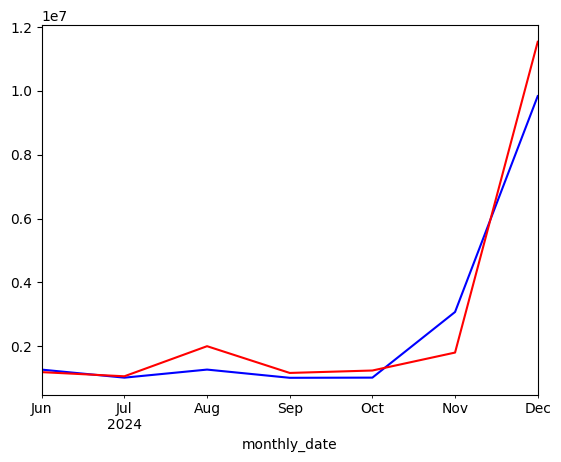

In [16]:
company_monthly_agg['units'].plot(color='blue')
company_monthly_agg['pred'].plot(color='red')

In [31]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(company_sales_by_monthly_test.units, company_sales_by_monthly_test.pred)
print(np.round(np.sqrt(mse),2))

mse_agg = mean_squared_error(company_monthly_agg.units, company_monthly_agg.pred)
print(np.round(np.sqrt(mse_agg), 2))

217135.95
855428.76


# Step 6 - Next Steps

In [ ]:
sales_by_store_flt = sales_by_store[sales_by_store['store'] == 'Store4']

# Apply Exponential Moving Average
sales_by_store_flt['ema'] = sales_by_store_flt['units'].ewm(span=5, adjust=False).mean()

# Plot the smoothed time series
sales_by_store_flt[['units', 'ema']].plot(figsize=(10, 6), title='Time Series with EMA')
plt.show()



# fig, ax = plt.subplots()

# sales_by_store_temp = sales_by_store[sales_by_store['store'] == 'Store1']
# sales_by_store_temp = sales_by_store_temp["2025-10-01":"2025-12-28"]

# ax.plot(sales_by_store_temp.index, sales_by_store_temp['units'])
# plt.show()

In [ ]:
'''
Step 0 - Getting Started
- Import Libraries
- Load Data

Step 1 - Data Cleaning
- Change Wide to Long Format
- Change Data Types
- Map Categorical Variables To Weekly Dates

Step 2 - Data Understanding
- Stats
- Plot ACF

Step 3 - Feature Engineering
- Lags
- Seasonal Pattern
- Month Encoded
- Store Encoded

Step 4 - Data Modeling
- Split Train and Test
- GridSearch
- Model

Step 5 - Data Evaluation
- RMSE

Step 6 - Next Steps
-
'''